In [47]:
import numpy as np
import time
from openpyxl import load_workbook
from itertools import islice
import numpy as np
import random
from gurobipy import *
import copy

def reconstruir_rutas(Rutas, routes, m):
    rutas_final = []
    routes = np.sort(routes)

    for pos in range(len(routes)):
        parcial_sol = []
        parcial_sol.append('0')
        if pos == 0:
            parcial_sol = parcial_sol + [node for node in Rutas[routes[pos]:routes[pos+1]]]
        elif pos == m-1:
            parcial_sol = parcial_sol + [node for node in Rutas[routes[pos]:]]
        else:
            parcial_sol = parcial_sol + [node for node in Rutas[routes[pos]:routes[pos+1]]]
        parcial_sol.append('0')
        rutas_final.append(parcial_sol)
    return rutas_final

def read_fsspsc(id):
    file_path = f'p{id}.vrp'

    datos_procesados = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

    i = 0
    for linea in lines[2:]:
        partes = linea.strip().split()  
        if len(partes) > 3:  
            segundo_numero = float(partes[1])  
            tercer_numero = float(partes[2]) 
            indice_del_cero = partes.index('0') 
            numero_despues_del_cero = float(partes[indice_del_cero + 1]) 
            if i == 0:
                datos_procesados.append([segundo_numero, tercer_numero, 0])
                i += 1
            else:
                datos_procesados.append([segundo_numero, tercer_numero, numero_despues_del_cero])

    dur = np.array(datos_procesados)
    m = int(lines[0][2]+lines[0][3]) #Number of vehicles
    if m > 9:
        n = int(lines[0][5]+lines[0][6]) #Number of nodes without the deposit
    else:
        n = int(lines[0][4]+lines[0][5]) #Number of nodes without the deposit 
    Q = int(lines[1][2]+lines[1][3]+lines[1][4]) #Capacity for each vehicle
    return n, m, Q, dur

def dist_euclidiana(x1,x2):
    t = np.sqrt((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)
    return round(t, 3)

def intercambiarNodoEnRuta(nodo, pos, solucion_actual_aux):
    solucion_actual_aux[pos] = f"{nodo}"
    return solucion_actual_aux

def calcular_long_total(ruta, edges):
    longitud = 0
    i = 0
    while i < len(ruta)-1:
        longitud = longitud + edges[(f"{ruta[i]}", f"{ruta[i+1]}")]
        i+=1
    return longitud

def insertarNodoEnRuta(nodo, pos, ruta):
    ruta = ruta[:pos] + [f"{nodo}"] + ruta[pos:]
    return ruta

def calcularRelacion(ruta, nodo, pos, edges, weights):
    Distancia_Antes = calcular_long_total(ruta, edges)
    ruta = insertarNodoEnRuta(nodo, pos, ruta)
    Distancia_Despues = calcular_long_total(ruta, edges)
    ruta.remove(str(nodo))
    if Distancia_Despues - Distancia_Antes == 0:
        return 0  
    else:
        return weights[str(nodo)] / (Distancia_Despues - Distancia_Antes)

def calcular_peso_total(ruta, weights):
    peso = 0
    i = 0
    while i < len(ruta)-1:
        peso= peso + weights[f"{ruta[i]}"]
        i+=1
    return peso

def ConstruirSolucionGreedyRandomizada(ruta_construida, edges, nodos, K, weights):
    while nodos:
        LRC = GenerarListaRestringidaDeCandidatos(ruta_construida, nodos, edges, weights, K)
        clave_aleatoria = random.choice(list(LRC.keys()))
        if len(ruta_construida) == 2:
            ruta_construida = insertarNodoEnRuta(clave_aleatoria, 1, ruta_construida)
        else:
            ruta_construida = insertarNodoEnRuta(clave_aleatoria, random.choice(range(1,len(ruta_construida)-1)), ruta_construida)
        nodos.remove(clave_aleatoria)
        break
    return ruta_construida, nodos

def GenerarListaRestringidaDeCandidatos(ruta_construida, nodos, edges, weights, k):
    if len(ruta_construida) == 2:
        pos = 1
    else:
        pos = random.randrange(1,len(ruta_construida)-1,1)
    relacion = {}
    for nodo in nodos:
            ruta_prov = insertarNodoEnRuta(nodo, pos, ruta_construida)
            relacion[f"{nodo}"] = calcular_long_total(ruta_prov, edges)
    relacion_ordenada  = sorted(relacion.items(), key=lambda item: item[1])
    primeros_k = islice(relacion_ordenada, k)
    Mejor_relación = dict(primeros_k)
    return Mejor_relación

def AplicarBusquedaLocal(solucion_actual, nodos, edges, weights,):
    longitud_total = calcular_long_total(solucion_actual, edges)
    while nodos:
        nodoSeleccionado = None
        posicionInsercion = None

        for nodo in nodos:
            i = 0
            while i < len(solucion_actual) - 1:
                i += 1
                ruta_provicional = insertarNodoEnRuta(nodo, i, solucion_actual)
                longitud_provicional = calcular_long_total(ruta_provicional, edges)
                if longitud_provicional < longitud_total:
                    nodoSeleccionado = nodo
                    posicionInsercion = i
                
        if nodoSeleccionado != None:
            solucion_actual = insertarNodoEnRuta(nodoSeleccionado, posicionInsercion, solucion_actual)
            nodos.remove(nodoSeleccionado)
        else:
            break
    return solucion_actual, nodos

def GRASP(n, k, edges, weights, dur):
    start_time = time.time()
    nodos = [str(nodo) for nodo in range(len(dur))]
    nodos_no_visitados = list(nodos[1:])
    solucion_actual = []
    solucion_actual = ['0']
    solucion_actual.append('0')

    while nodos_no_visitados:
        solucion_provicional, nodos_no_visitados = ConstruirSolucionGreedyRandomizada(solucion_actual, edges, nodos_no_visitados, k, weights)
        solucion_mejorada, nodos_no_visitados = AplicarBusquedaLocal(solucion_provicional, nodos_no_visitados, edges, weights)
        solucion_actual = solucion_mejorada
    longitud_total = calcular_long_total(solucion_actual, edges)
    round(longitud_total, 3)
    ruta = solucion_actual

    end_time = time.time()
    elapsed_time = round((end_time - start_time) * 1000)
    return ruta, longitud_total

def calcular(dur):
    edges = {}
    dur_edges = dur[:,0:2].copy()
    dur_weights = dur[:, -1].copy()
    weights = {}
    i = 0

    while i < len(dur_edges):
        j = i + 1
        weights[f"{i}"] = dur_weights[i]
        while j < len(dur_edges):
            edges[(f"{i}", f"{j}")]=(dist_euclidiana(dur_edges[i],dur_edges[j]))
            edges[(f"{j}", f"{i}")]=(dist_euclidiana(dur_edges[i],dur_edges[j]))
            j += 1
        i += 1
    return edges, weights

def calcular_costo_ruta(Rutas, edges, ruta_actual):
    costo = 0
    for i in range(len(ruta_actual)-1):
        costo += edges[(f'{Rutas[ruta_actual[i]]}',f'{Rutas[ruta_actual[i+1]]}')]
    return costo

def split_algorithm_fixed_fleet(n, Q, q, Rutas, s, m, edges):
    p = 3  # Número de sublistas en cada lista principal 
    V = [[float('inf')] * (n+1) for _ in range(p)]
    W = [[float('inf')] * (n+2) for _ in range(p)]
    # m Número de listas principales
    # n Número de elementos en cada sublista
    P = [[[0] * (n+1) for _ in range(m)] for _ in range(p)]
    for i in range(p): 
        V[i][0] = 0
        W[i][0] = 0
        W[i][-1] = 0
    for k in range(m):
        for i in range(1, n+2):
            j = i
            load = 0
            while j <= n and load <= Q:
                load += q[j] 
                if i == j:
                    Ruta1 = [0,i,0]
                    cost1 = calcular_costo_ruta(Rutas, edges, Ruta1) + s[i]
                    Ruta2 = [0,i+1,0]
                    cost2 = calcular_costo_ruta(Rutas, edges, Ruta2) + s[i+1]
                    Ruta3 = [0,i+2,0]
                    cost3 = calcular_costo_ruta(Rutas, edges, Ruta3) + s[i+2]
                else:
                    if j == i+1:
                        Ruta1.insert(2, j)
                        cost1 = calcular_costo_ruta(Rutas, edges, Ruta1) + s[j]
                        Ruta2.insert(2, j-1)
                        cost2 = calcular_costo_ruta(Rutas, edges, Ruta2) + s[j-1]
                        Ruta3.insert(2, j-1)
                        cost3 = calcular_costo_ruta(Rutas, edges, Ruta3) + s[j-1]
                    elif j == i+2:
                        Ruta1.insert(3, j)
                        cost1 = calcular_costo_ruta(Rutas, edges, Ruta1) + s[j]
                        Ruta2.insert(2, j)
                        cost2 = calcular_costo_ruta(Rutas, edges, Ruta2) + s[j]
                        Ruta3.insert(3, j-1)
                        cost3 = calcular_costo_ruta(Rutas, edges, Ruta3) + s[j-1]
                    else:
                        if cost2 < cost3 or cost2 == cost3:
                            pos  = Ruta2.index(max(Ruta2))
                            Ruta2.insert(pos+1, j)
                            cost2 = calcular_costo_ruta(Rutas, edges, Ruta2) + s[j]
                        else:
                            Ruta2 = copy.deepcopy(Ruta3)
                            pos  = Ruta2.index(max(Ruta2))
                            Ruta2.insert(pos+1, j)
                            cost2 = calcular_costo_ruta(Rutas, edges, Ruta2) + s[j]
                        Ruta3 = copy.deepcopy(Ruta1)
                        Ruta1.insert(-1, j)
                        cost1 = calcular_costo_ruta(Rutas, edges, Ruta1) + s[j]
                        Ruta3.insert(1, j)
                        cost3 = calcular_costo_ruta(Rutas, edges, Ruta3) + s[j]
                if load <= Q and ((W[0][i-1] + cost1) < V[0][j]):
                    V[0][j] = W[0][i-1] + cost1
                    if i == 0:
                        P[0][k][j] = i
                    else:
                        P[0][k][j] = i - 1
                if load <= Q and ((W[1][i-1] + cost2) < V[1][j]):
                    V[1][j] = W[1][i-1] + cost2
                    if i == 0:
                        P[1][k][j] = i
                    else:
                        P[1][k][j] = i - 1
                if load <= Q and ((W[2][i-1] + cost3) < V[2][j]):
                    V[2][j] = W[2][i-1] + cost3
                    if i == 0:
                        P[2][k][j] = i
                    else:
                        P[2][k][j] = i - 1
                j += 1
            
            if W[0][i] == float('inf'):
                break
        for u in range(p):
            for z in range(n):
                W[u][z] = V[u][z]
    routes = [[] for _ in range(p)]
    for t in range(p):
        if P[t][-1][-1] == 0 :
            if P[t][-1][-2] != 0 :
                j = n-2
            elif P[t][-1][-2] == 0 :
                if P[t][-1][-3] != 0 :
                    j = n-3
                else:
                    return V, [], []
            else:
                return V, [], []
        elif P[t][-1][-1] != 0 :
            j = n-1

        k = m-1
        while k >= 0:
            i = P[t][k][j]
            routes[t].append(i)
            j = i
            k -= 1
    return V, P, routes

# In[21]:


routes_set_partitiong = []
K = 5
nsol = 30
id = '01'
n,m,Q,dur = read_fsspsc(id)
edges, weights = calcular(dur)
distance=[]
demands = []

for _ in range(nsol):
    Rutas, longitud=GRASP(n,K, edges, weights, dur)
    Rutas.pop()
    n_aux = len(Rutas)  # Número de puntos únicos según el orden especificado
    s = [0 for _ in Rutas]
    q = [weights[node] for node in Rutas]
    nodos = [str(node) for node in range(51)]
    V, P, routes = split_algorithm_fixed_fleet(n, Q, q, Rutas, s, m, edges)
    if P == []:
        continue
    Rutas.pop(0)
    for ñ in range(len(routes)):
        rutas_final = reconstruir_rutas(Rutas, routes[ñ], m)
        for x in rutas_final:
            x_aux = copy.deepcopy(x)
            x_aux.pop()
            x_aux.pop(0)
            lista_enteros = [int(numero) for numero in x_aux]
            if lista_enteros not in routes_set_partitiong:
                if calcular_peso_total(x, weights) <= Q: 
                    demands.append(sum([weights[node] for node in x]))
                    suma = 0
                    for y in range(len(x)-1):
                        suma +=  edges[(x[y],x[y+1])]
                    distance.append(suma)
                    x.pop()
                    x.pop(0)
                    lista_enteros = [int(numero) for numero in x]
                    routes_set_partitiong.append(lista_enteros)
    

In [48]:
Number_cars = m
Number_nodes = n


nodes = [u for u in range(1,Number_nodes+1)]
# Create a new model
model = Model("myModel")
# Add variables
x = [model.addVar(vtype=GRB.BINARY, name=f"x_{i}") for i in range(len(routes_set_partitiong))] #Si se escoge la ruta i

lambda_ij = [[] for _ in range(len(routes_set_partitiong))]
for i in range(len(routes_set_partitiong)):
    lambda_ij[i] = np.zeros(n)
    for j in routes_set_partitiong[i]:
        lambda_ij[i][j-1] = 1

# # Set objective

objective = quicksum(distance[i] * x[i] for i in range(len(routes_set_partitiong)))
model.setObjective(objective, GRB.MINIMIZE)

# # Add constraint:
model.addConstr(quicksum(x[i] for i in range(len(routes_set_partitiong))) == Number_cars, "paths_equals_cars")

# constraints for each node
for j in nodes:
     model.addConstr(quicksum(lambda_ij[i][j-1] * x[i] for i in range(len(routes_set_partitiong))) == 1, f"visit_node_{j}")
    # model.addConstr(quicksum(routes_set_partitiong[i][j] * x[i] for i in range(len(routes_set_partitiong))) == 1, f"visit_node_{j}")


model.optimize()
conteo = 0
rutas = []

        
if model.status == GRB.Status.OPTIMAL:
    print('Optimal solution found:')
    for v in model.getVars():
        if v.x >0.1:
            name = v.varName
            print(f'{name} = {v.x}')
            last_two_chars = name[-2:]
            index = int(last_two_chars)
            print(routes_set_partitiong[index])
            conteo += len(routes_set_partitiong[index])
            rutas.append(routes_set_partitiong[index])
    print(f'Objective Value: {model.objVal}')
else:
    print('No optimal solution found.')

print(conteo)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 51 rows, 180 columns and 1928 nonzeros
Model fingerprint: 0x812ea2a9
Variable types: 0 continuous, 180 integer (180 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 51 rows and 180 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 1579.8 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.579805000000e+03, best bound 1.579805000000e+03, gap 0.0000%
Optimal solution found:
x_80 = 1.0
[2, 32, 26, 28, 36, 13, 35, 

In [49]:

medias_demanda = []
for x in rutas:
    demanda = []
    for y in x:
        demanda.append(weights[f'{y}'])
    medias_demanda.append(demanda)


resultados = []
for idx, ruta in enumerate(rutas):
    carga_actual = 0
    visitas = []  # Registra las visitas a cada nodo
    for i, nodo in enumerate(ruta):
        demanda = np.random.normal(medias_demanda[idx][i], 8)  # Desviación estándar arbitraria de 10
        if carga_actual + demanda > Q:
            # Regresar al depósito y continuar
            visitas.append(0)
            carga_actual = 0  # Reinicia la carga del vehículo
        carga_actual += demanda
        visitas.append(nodo)
    # Prever la demanda del siguiente nodo y decidir si regresar al depósito antes de visitarlo
        if i < len(ruta) - 1:  # Asegurarse de que no es el último nodo
            demanda_siguiente_nodo = np.random.normal(medias_demanda[idx][i + 1], 8)
            if carga_actual + demanda_siguiente_nodo > Q:
                visitas.append(0)  # Regresar al depósito
                carga_actual = 0  # Reiniciar la carga del vehículo
    visitas.insert(0,0)
    visitas.append(0)
    resultados.append(visitas)

dist_total = 0
# Imprimir resultados de la simulación
for idx, resultado in enumerate(resultados):
    print(f"Ruta {idx+1}: {resultado}", calcular_long_total(resultado, edges), len(resultado))
    dist_total+=calcular_long_total(resultado, edges)
print(f'La distancia total es: {dist_total}')

Ruta 1: [0, 2, 32, 26, 28, 36, 13, 35, 0, 8, 20, 0] 354.647 12
Ruta 2: [0, 41, 1, 14, 33, 19, 17, 9, 34, 49, 24, 0] 320.20300000000003 12
Ruta 3: [0, 7, 11, 25, 48, 22, 21, 45, 0, 18, 37, 0] 283.932 12
Ruta 4: [0, 31, 5, 44, 15, 3, 43, 38, 39, 30, 6, 29, 0] 384.70899999999995 13
Ruta 5: [0, 42, 12, 10, 16, 50, 46, 4, 27, 23, 40, 47, 0] 280.987 13
La distancia total es: 1624.478


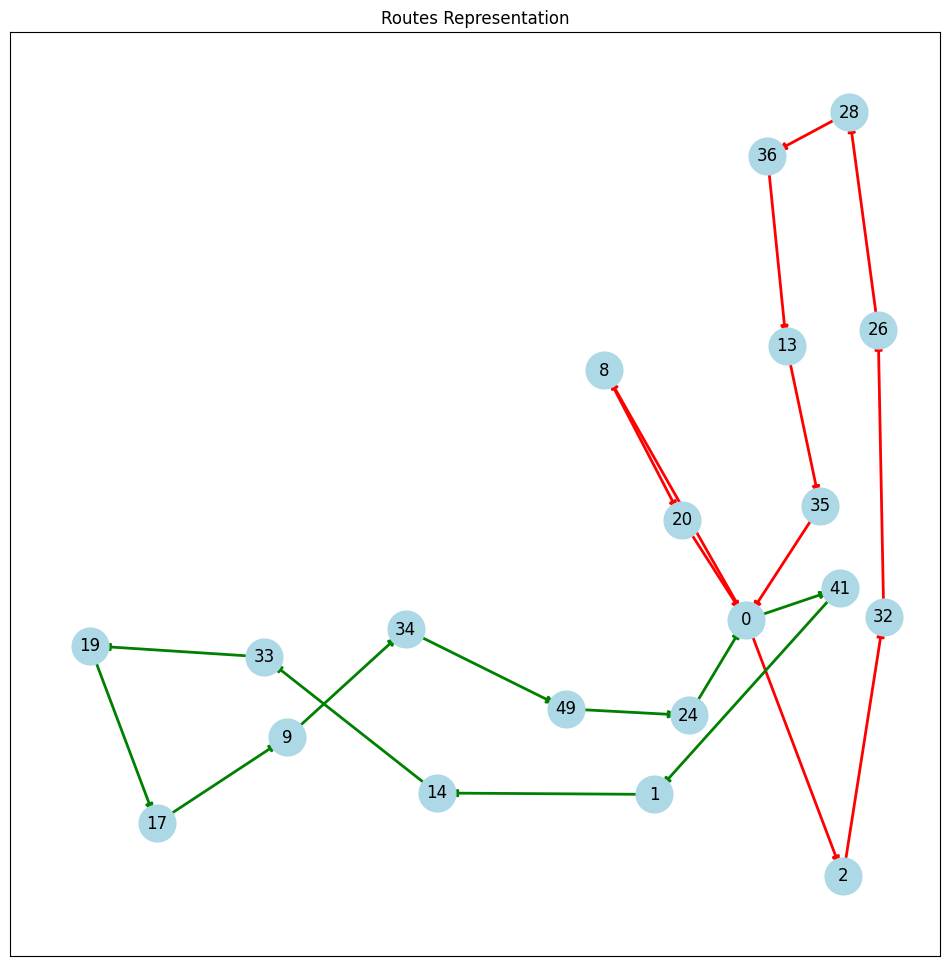

In [50]:
import networkx as nx
import matplotlib.pyplot as plt
# Crear el grafo
G = nx.DiGraph()

# Añadir nodos y aristas al grafo
for ruta in resultados[:2]:
    edges_ruta = [(ruta[i], ruta[i+1]) for i in range(len(ruta) - 1)]
    G.add_edges_from(edges_ruta)

# Definir la posición de los nodos en el gráfico
pos = nx.spring_layout(G)

# Dibujar el grafo
plt.figure(figsize=(12, 12))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'orange', 'purple']
for idx, ruta in enumerate(resultados[:2]):
    edges_ruta = [(ruta[i], ruta[i+1]) for i in range(len(ruta) - 1)]
    nx.draw_networkx_edges(G, pos, edgelist=edges_ruta, edge_color=colors[idx], width=2.0)
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

plt.title('Routes Representation')
plt.show()

In [51]:
import numpy as np

## Estado inicial de cada vehículo
estado_vehiculos = [{
    'ruta': ruta,
    'carga': 0,
    'posicion': 0,
    'visitas': [0]
} for ruta in rutas]

# Simulación en paralelo de todas las rutas
while any(v['posicion'] < len(v['ruta']) for v in estado_vehiculos):
    for idx, vehiculo in enumerate(estado_vehiculos):
        if vehiculo['posicion'] >= len(vehiculo['ruta']):
            continue  # Este vehículo ya completó su ruta
        nodo_actual = vehiculo['ruta'][vehiculo['posicion']]
        demanda_actual = max(0, np.random.normal(medias_demanda[idx][vehiculo['posicion']], 8))

        # Decidir si necesita volver al depósito antes de proceder
        if vehiculo['carga'] + demanda_actual > Q:
            vehiculo['visitas'].append(0)
            vehiculo['carga'] = 0
        
        # Verificar ayuda de otros vehículos en los últimos 4 nodos
        if vehiculo['posicion'] >= len(vehiculo['ruta']) - 4:
            ayuda_posible = False
            for otro in estado_vehiculos:
                if otro == vehiculo or otro['posicion'] >= len(otro['ruta']):
                    continue
                siguiente_nodo_otro = otro['ruta'][otro['posicion']]
                if otro['carga'] + demanda_actual <= Q and edges[(f'{nodo_actual}',f'{siguiente_nodo_otro}')] < edges[(f'{nodo_actual}','0')]:
                    # El otro vehículo puede ayudar
                    otro['visitas'].append(nodo_actual)
                    otro['carga'] += demanda_actual
                    ayuda_posible = True
                    break
            if not ayuda_posible:
                vehiculo['carga'] += demanda_actual
                vehiculo['visitas'].append(nodo_actual)
        else:
            vehiculo['carga'] += demanda_actual
            vehiculo['visitas'].append(nodo_actual)

        vehiculo['posicion'] += 1

    # Volver al depósito si es el fin de la ruta
    for vehiculo in estado_vehiculos:
        if vehiculo['posicion'] >= len(vehiculo['ruta']):
            if vehiculo['visitas'][-1] != 0:
                vehiculo['visitas'].append(0)
            
resultados_no = []

dist_total = 0
# Imprimir los resultados
for idx, vehiculo in enumerate(estado_vehiculos):
    print(f"Ruta {idx+1}: {vehiculo['visitas']}", calcular_long_total(vehiculo['visitas'], edges), len(vehiculo['visitas']))
    dist_total+=calcular_long_total(vehiculo['visitas'], edges)
    resultados_no.append(vehiculo['visitas'])
print(f'La distancia total es: {dist_total}')

Ruta 1: [0, 2, 32, 26, 28, 36, 21, 34, 0] 161.008 9
Ruta 2: [0, 41, 1, 14, 33, 19, 13, 17, 35, 39, 0] 357.482 11
Ruta 3: [0, 7, 11, 25, 48, 22, 18, 49, 37, 0] 237.981 10
Ruta 4: [0, 31, 5, 44, 15, 3, 43, 9, 45, 38, 0, 20, 30, 23, 24, 6, 29, 0] 519.4749999999999 18
Ruta 5: [0, 42, 12, 10, 16, 50, 46, 4, 8, 27, 40, 47, 0] 288.56100000000004 13
La distancia total es: 1564.507


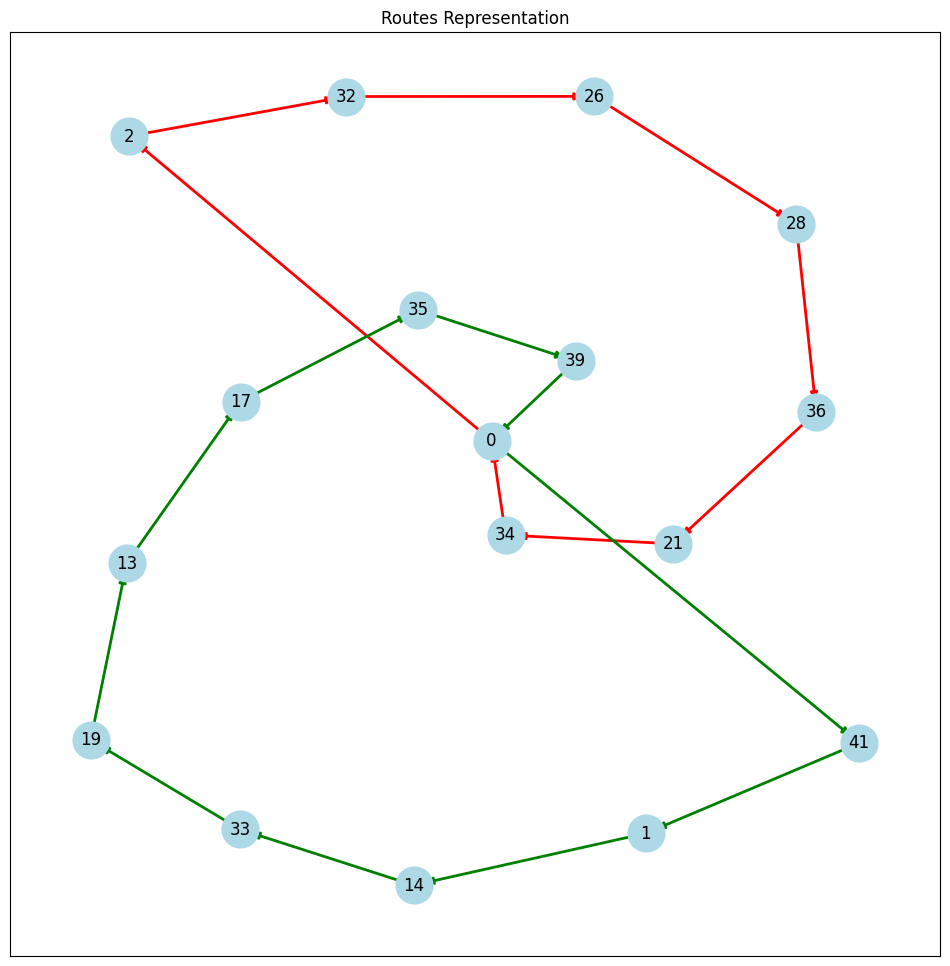

In [52]:
# Crear el grafo
G = nx.DiGraph()

# Añadir nodos y aristas al grafo
for ruta in resultados_no[:2]:
    edges_ruta = [(ruta[i], ruta[i+1]) for i in range(len(ruta) - 1)]
    G.add_edges_from(edges_ruta)

# Definir la posición de los nodos en el gráfico
pos = nx.spring_layout(G)

# Dibujar el grafo
plt.figure(figsize=(12, 12))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'orange', 'purple']
for idx, ruta in enumerate(resultados_no[:2]):
    edges_ruta = [(ruta[i], ruta[i+1]) for i in range(len(ruta) - 1)]
    nx.draw_networkx_edges(G, pos, edgelist=edges_ruta, edge_color=colors[idx], width=2.0)
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

plt.title('Routes Representation')
plt.show()